#**Big Data Application in E-commense**
##——Customer Recommendation Strategy
###Project Contributor : **Tao Liu**

---

In this project, The [Amazon Review Data](http://deepyeti.ucsd.edu/jianmo/amazon/index.html) will be used as database. The [User-Based Collaborative Filtering](https://medium.com/sfu-cspmp/recommendation-systems-user-based-collaborative-filtering-using-n-nearest-neighbors-bf7361dc24e0) method will be performed to give customers potential Recommedations on which item they may want to purchase next. 

The features for this strategy will be customer's **Also View Records** and **Also Buy Records**.

##**Step 0** - Package import
---
All the packages will be imported here.

In [58]:
import numpy as np
import sklearn
import os
import json
import gzip
import pandas as pd
from urllib.request import urlopen
import requests
import array
import collections
from sklearn.metrics.pairwise import cosine_similarity
from operator import itemgetter
! python --version
! pip install cloudmesh-common -U
from cloudmesh.common.StopWatch import StopWatch
from cloudmesh.common.Benchmark import Benchmark
import scipy
import random

Python 3.6.9
Requirement already up-to-date: cloudmesh-common in /usr/local/lib/python3.6/dist-packages (4.3.26)


##**Step 1** - Data Implemtation
---

We will start with Amazon Review Data implementation and give a raw database to the local environment.



In [59]:
StopWatch.start("Data Online Downloading Process")
!wget http://deepyeti.ucsd.edu/jianmo/amazon/metaFiles/meta_Gift_Cards.json.gz
StopWatch.stop("Data Online Downloading Process")
StopWatch.status("Data Online Downloading Process", True)

--2020-12-06 13:23:51--  http://deepyeti.ucsd.edu/jianmo/amazon/metaFiles/meta_Gift_Cards.json.gz
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 380174 (371K) [application/octet-stream]
Saving to: ‘meta_Gift_Cards.json.gz.1’

meta_Gift_Cards.jso 100%[===================>] 371.26K   707KB/s    in 0.5s    

2020-12-06 13:23:52 (707 KB/s) - ‘meta_Gift_Cards.json.gz.1’ saved [380174/380174]







The Raw Database presents in the following:

In [60]:
def parse(path):
    g = gzip.open(path, 'r')
    for l in g:
      yield json.dumps(eval(l))
def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
      df[i] = d
      i += 1
    return pd.DataFrame.from_dict(df, orient='index')
def raw_database():
    f = open("output.strict", 'w')
    for l in parse("meta_Gift_Cards.json.gz"):
            (f.write(l + '\n'))
    df = getDF('meta_Gift_Cards.json.gz')
    return df
#running the function 
StopWatch.start("Raw Database")
df = raw_database()
StopWatch.stop("Raw Database")
StopWatch.status("Raw Database", True)

##**Step 2** - Data Cleaning and Reformatting
---
Since the raw data Implemented is alphapet character **"B00H5BPJQC"** rather than numeric character **"1"**, it will be required to reformat for the strategy identification purpose. 



The limited data attributes(**"asin","also_like","also_view"**) would be considered from the attribute based on their Relevance to Customer's Recommendation Strategy.  

In [61]:
def build_database(asin_dict):
    f = open("output.strict", 'w')
    for l in parse("meta_Gift_Cards.json.gz"):
          (f.write(l + '\n'))
    df = getDF('meta_Gift_Cards.json.gz')[0]
    length = len(df)
    n = 2000
    #also_view
    also_view_dict ={}
    also_view = []
    for i in df:
          dictionary = json.loads(i)
          asin =dictionary['asin']
          asin = asin_dict[asin]
          also_view_raw = dictionary['also_view']
          sub_list1=[]
          for j in also_view_raw:
                try:
                    sub_list1.append(asin_dict[j])
                    also_view_dict.setdefault(asin_dict[j],[]).append(asin)
                except:
                    sub_list1.append(n)
                    also_view_dict.setdefault(n,[]).append(asin)
                    asin_dict[j] = n
                    n = n+1
          also_view.append(sub_list1)
    #also_buy
    also_buy_dict ={}
    also_buy = []
    for i in df:
          dictionary = json.loads(i)
          asin =dictionary['asin']
          asin = asin_dict[asin]
          also_buy_raw = dictionary['also_buy']
          sub_list2=[]
          for k in also_buy_raw:
                try:
                    sub_list2.append(asin_dict[k])
                    also_buy_dict.setdefault(asin_dict[k],[]).append(asin)
                except:
                    sub_list2.append(n)
                    also_buy_dict.setdefault(n,[]).append(asin)
                    asin_dict[k] = n
                    n = n+1
          also_buy.append(sub_list2)  
    return  also_view,also_buy,also_view_dict,also_buy_dict,asin_dict
def reformat_asin(df):
    asin_dict = {}
    n = 0
    for i in df[0]:
          dictionary = json.loads(i)
          asin = dictionary['asin']
          asin_dict[asin] = n
          n = n+1
    return asin_dict
# running the function    
StopWatch.start("Database Reformatting process")    
asin_dict = reformat_asin(df)
also_view,also_buy,also_view_dict,also_buy_dict,asin_dict = build_database(asin_dict)
StopWatch.stop("Database Reformatting process")
StopWatch.status("Database Reformatting process", True)

##**Step 3** - Data Presentation
---
Here will given a brief presentation for the reformat dataset. 

In [62]:
def list_presentation(list,start_number, end_number):
  for i in range(start_number,end_number):
    try:
      print("Item ",i,": ",list[i])
    except:
      print("Item ",i, ":  do not have sub_items in it")

print(len(asin_dict)," Lines of Reformatted ASIN Reference dictionary")
print(asin_dict)
print("---------------------------------------------------")
print("also_view List: The first 20 lines")
list_presentation(also_view,0,20)
print("---------------------------------------------------")
print("also_buy List: The first 20 lines")
list_presentation(also_buy,0,20)
print("---------------------------------------------------")
print("also_view Dictionary: Item 2000 to 2020")
list_presentation(also_view_dict,2000,2020)
print("---------------------------------------------------")
print("also_buy Dictionary: Item 2000 to 2020")
list_presentation(also_buy_dict,2000,2020)
print(len(also_buy))

4561  Lines of Reformatted ASIN Reference dictionary
{'B001BKEWF2': 0, 'B001GXRQW0': 1, 'B001H53QE4': 2, 'B001H53QEO': 3, 'B001KMWN2K': 4, 'B001M1UVQO': 5, 'B001M1UVZA': 6, 'B001M5GKHE': 7, 'B002BSHDJK': 8, 'B002DN7XS4': 9, 'B002H9RN0C': 10, 'B002MS7BPA': 11, 'B002NZXF9S': 12, 'B002O018DM': 13, 'B002O0536U': 14, 'B002OOBESC': 15, 'B002PY04EG': 16, 'B002QFXC7U': 17, 'B002QTM0Y2': 18, 'B002QTPZUI': 19, 'B002SC9DRO': 20, 'B002UKLD7M': 21, 'B002VFYGC0': 22, 'B002VG4AR0': 23, 'B002VG4BRO': 24, 'B002W8YL6W': 25, 'B002XNLC04': 26, 'B002XNOVDE': 27, 'B002YEWXZ0': 28, 'B002YEWXMI': 29, 'B003755QI6': 30, 'B003CMYYGY': 31, 'B003NALDC8': 32, 'B003XNIBTS': 33, 'B003ZYIKDM': 34, 'B00414Y7Y6': 35, 'B0046IIHMK': 36, 'B004BVCHDC': 37, 'B004CG61UQ': 38, 'B004CZRZKW': 39, 'B004D01QJ2': 40, 'B004KNWWPE': 41, 'B004KNWWP4': 42, 'B004KNWWR2': 43, 'B004KNWWRC': 44, 'B004KNWWT0': 45, 'B004KNWWRW': 46, 'B004KNWWQ8': 47, 'B004KNWWNG': 48, 'B004KNWWPO': 49, 'B004KNWWXQ': 50, 'B004KNWWUE': 51, 'B004KNWWYU': 52, 'B

##**Step 4** - Recommendation Rate Calculation
---
The logic for Recommendation Rate Calculation:

If Customer A purchase Item 1, and Item 2 appears in the also_like or also_view list in Item 2, then the Item 2's similarity to Item 1 will be affected. 


The recommendation rate calculation function is presented in the following:


In [63]:
StopWatch.start("Recommendation Rate Calculation")
def itemtoitem_relationship(also_view,also_buy,also_view_dict,also_buy_dict,asin_dict):
  matrix =[]
  for itemNO in range(0,1547):
      asin_list = [0]*len(asin_dict)
      for asin in also_view[itemNO]:
          try:
            asin_list[asin] = asin_list[asin]+2
          except:
            pass
          try:
              for i in also_view_dict[asin]:
                asin_list[i] = asin_list[i]+2
          except:
              pass
      for asin in also_buy[itemNO]:
          try:
               for i in also_buy_dict[asin]:
                asin_list[i] = asin_list[i]+10
          except:
              pass
          try:
              for i in also_buy_dict[asin]:
                asin_list[i] = asin_list[i]+10
          except:
              pass
      try:
        avg = (len(also_view[itemNO]) + len(also_buy[itemNO]))/2
      except:
        avg = 0
      asin_list = [i if i != 0 else avg for i in asin_list]
      matrix. append(asin_list)
  return matrix
matrix = itemtoitem_relationship(also_view,also_buy,also_view_dict,also_buy_dict,asin_dict)
StopWatch.stop("Recommendation Rate Calculation")
StopWatch.status("Recommendation Rate Calculation", True)
def matrix_presentation(list,start_number, end_number):
  for i in range(start_number,end_number):
    try:
      print("Item ",i,": ",list[i][:20])
    except:
      print("Item ",i, ":  do not have sub_items in it")
print("The matrix represents for the recommendation rate: The first 20 lines")
matrix_presentation(matrix,0,20)

The matrix represents for the recommendation rate: The first 20 lines
Item  0 :  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Item  1 :  [13.0, 52, 28, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 2, 2, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0]
Item  2 :  [29.5, 28, 262, 29.5, 29.5, 29.5, 29.5, 29.5, 29.5, 29.5, 29.5, 4, 2, 29.5, 29.5, 29.5, 29.5, 29.5, 29.5, 29.5]
Item  3 :  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Item  4 :  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Item  5 :  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Item  6 :  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Item  7 :  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Item  8 :  [1

##**Step 5** - Recommendation Strategy similarity Calculation
Here the [Cosine Similarity Strategy](https://medium.com/sfu-cspmp/recommendation-systems-user-based-collaborative-filtering-using-n-nearest-neighbors-bf7361dc24e0) will be used to calculate the similarity.


In [64]:
StopWatch.start("Consine_Similarity")
cosine = cosine_similarity(matrix)
np.fill_diagonal(cosine, 0 )
print("A shortcut for the similarity table will be the following:")
StopWatch.stop("Consine_Similarity")
StopWatch.status("Consine_Similarity", True)
similarity_example =pd.DataFrame(cosine)
similarity_example.head()

A shortcut for the similarity table will be the following:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,1507,1508,1509,1510,1511,1512,1513,1514,1515,1516,1517,1518,1519,1520,1521,1522,1523,1524,1525,1526,1527,1528,1529,1530,1531,1532,1533,1534,1535,1536,1537,1538,1539,1540,1541,1542,1543,1544,1545,1546
0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
1,0.0,0.000000,0.890063,0.0,0.0,0.0,0.0,0.0,0.786877,0.0,0.932718,0.895627,0.718031,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.957735,0.585418,0.773526,0.940168,0.585418,0.820201,0.879648,0.863465,0.0,0.0,0.901829,0.910500,0.683694,0.789377,0.603901,0.887253,0.817321,0.774620,0.792217,0.722086,0.665912,0.904253,0.905845,0.469365,0.904549,0.879766,0.388219,0.382081,0.396419,0.406691,0.397777,0.559946,0.408435,0.315043,0.0,0.400746,0.276884,0.411715,0.876188
2,0.0,0.890063,0.000000,0.0,0.0,0.0,0.0,0.0,0.792327,0.0,0.893316,0.879156,0.723858,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.915835,0.775417,0.818287,0.838944,0.775417,0.867305,0.895337,0.866756,0.0,0.0,0.907512,0.786466,0.858621,0.894584,0.767688,0.928446,0.864662,0.892056,0.901718,0.874148,0.852872,0.910885,0.927415,0.608400,0.911404,0.920430,0.609483,0.607542,0.625588,0.638757,0.629881,0.765222,0.641101,0.531654,0.0,0.630702,0.498406,0.642654,0.895384
3,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
4,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000


##**Step 6** - Euclidean distance Similarity Calculation
Here the [Euclidean Distance Strategy](https://medium.com/dataseries/similarity-and-distance-metrics-for-data-science-and-machine-learning-e5121b3956f8) will be used to calculate the similarity.

In [65]:
StopWatch.start("Euclidean distance")
euc = scipy.spatial.distance_matrix(matrix,matrix)
StopWatch.stop("Euclidean distance")
StopWatch.status("Euclidean distance", True)

In [66]:
matrix_presentation(euc,0,20)

Item  0 :  [   0.         1005.70671669 2186.25947682    0.            0.
    0.            0.            0.         1138.04217848    0.
  108.63010632  162.86190469   49.06882921    0.            0.
    0.            0.            0.            0.            0.        ]
Item  1 :  [1005.70671669    0.         1370.09142031 1005.70671669 1005.70671669
 1005.70671669 1005.70671669 1005.70671669  710.89169358 1005.70671669
  905.23339532  862.88933242  971.0745337  1005.70671669 1005.70671669
 1005.70671669 1005.70671669 1005.70671669 1005.70671669 1005.70671669]
Item  2 :  [2186.25947682 1370.09142031    0.         2186.25947682 2186.25947682
 2186.25947682 2186.25947682 2186.25947682 1460.19211065 2186.25947682
 2089.78886493 2044.5519069  2151.0070316  2186.25947682 2186.25947682
 2186.25947682 2186.25947682 2186.25947682 2186.25947682 2186.25947682]
Item  3 :  [   0.         1005.70671669 2186.25947682    0.            0.
    0.            0.            0.         1138.04217848    0.

##**Step 7**  Recommendation Strategy Showcase
Here the strategy showcase will be presented:

For example, suppose Customer A purchase gift card ["B00H5BPJQC","B00GOLH1LK","B002NZXF9S"], the system can based on the cosine_similarity in the last step to calculate a list of recommendation goods for him. 

In [67]:
database = ["B00H5BPJQC"]
reformat_database = [asin_dict[i] for i in database]
def recommedndation_based_on_purchased_cos(reformat_database,n,method):
  possibility_list =[1]*1547
  for i in reformat_database:
    possibility_list = [a+b for a, b in zip(possibility_list, method[i])]
  index_sorted = np.argsort(possibility_list)[::-1][:n]
  return [list(asin_dict.keys())[list(asin_dict.values()).index(n)] for n in index_sorted]
def recommedndation_based_on_purchased_euc(reformat_database,n,method):
  possibility_list =[1]*1547
  for i in reformat_database:
    possibility_list = [a+b for a, b in zip(possibility_list, method[i])]
  index_sorted = np.argsort(possibility_list)[:n]
  return [list(asin_dict.keys())[list(asin_dict.values()).index(n)] for n in index_sorted]
print("Here is the database inserted, which represent three items customer already purchased at that time: ", database)
n = 5
print("Suppose we want to give him a recommendation on", n ," items he might purchase next: ")
StopWatch.start("Showcase-Cosine_Similarity")
list_cosine = recommedndation_based_on_purchased_cos(reformat_database,n,cosine)
print("it will return you the list of recommendation based on Consine Similarity: ",list_cosine)
StopWatch.stop("Showcase-Cosine_Similarity")
StopWatch.status("Showcase-Cosine_Similarity", True)
StopWatch.start("Showcase-Euclidean distance")
list_euc = recommedndation_based_on_purchased(reformat_database,n,euc)
print("it will return you the list of recommendation based on Euclidean distance: ",list_euc)
StopWatch.stop("Showcase-Euclidean distance")
StopWatch.status("Showcase-Euclidean distance", True)

Here is the database inserted, which represent three items customer already purchased at that time:  ['B00H5BPJQC']
Suppose we want to give him a recommendation on 5  items he might purchase next: 
it will return you the list of recommendation based on Consine Similarity:  ['B00GXSDWXU', 'B00H5BO6P2', 'B00H5BOVMK', 'B00H5BOFLM', 'B00H5BO5VW']
it will return you the list of recommendation based on Euclidean distance:  ['B00BXLSZPM', 'B00PG23QFI', 'B00GOLGWVK', 'B00BXLVHZM', 'B00BXLSPGQ']


##**Step 8**  Similarity Methods Accuracy and Time Comparsion
Here is  the two similarity methods: Cosine Similarity and Euclidean Distance similarity accuracy and running time comparsion

In [68]:
import matplotlib.pyplot as plt
import pylab as pl
from matplotlib import collections  as mc
def accuracy(n):
  all_right = 0
  dismiss = 0
  cos_accuracy = 0
  euc_accuracy = 0
  for i in range(0,1000):
    reformat_database = []
    for i in range(0,n):
      ran = random.randint(0,1545)
      reformat_database.append(ran)
    list_cosine = recommedndation_based_on_purchased(reformat_database,1,cosine)
    list_euc = recommedndation_based_on_purchased(reformat_database,1,euc)
    list_cosine = [asin_dict[i] for i in list_cosine]
    list_euc = [asin_dict[i] for i in list_euc] 
    cos_special = list_cosine[0]
    euc_special = list_euc[0]
    orginal = reformat_database[0]
    if  matrix[orginal][cos_special] == max(matrix[orginal]):
      cos_accuracy = cos_accuracy +1
      if matrix[orginal][euc_special] == max(matrix[orginal]):
        euc_accuracy = euc_accuracy +1
        all_right = all_right +1
    else:
      if matrix[orginal][euc_special] == max(matrix[orginal]):
        euc_accuracy = euc_accuracy +1
      else:
        dismiss = dismiss +1
  return   all_right, dismiss, cos_accuracy, euc_accuracy

StopWatch.start("Accuracy")
all_right_list =[]
cos_accuracy_list =[]
euc_accuracy_list =[]
dismiss_list =[]
for i in range(1,11):
  all_right, dismiss, cos_accuracy, euc_accuracy = accuracy(i)
  all_right_list.append(all_right)
  dismiss_list.append(dismiss)
  cos_accuracy_list.append(cos_accuracy)
  euc_accuracy_list.append(euc_accuracy)

StopWatch.stop("Accuracy")
StopWatch.status("Accuracy", True)

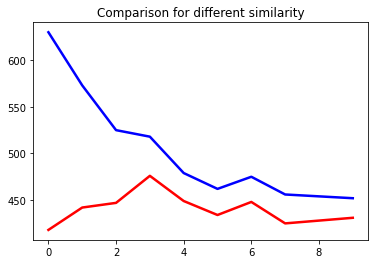

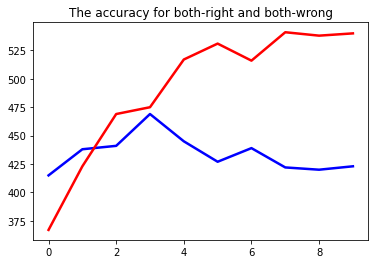

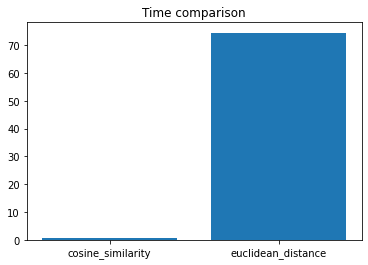

In [69]:
plt.title("Comparison for different similarity")
plt.plot(cos_accuracy_list, linewidth=2.5, linestyle="-", label="cosine",color ="blue")
plt.plot(euc_accuracy_list,linewidth=2.5, linestyle="-",label="euclidean",color ="red")
plt.show()
plt.title("The accuracy for both-right and both-wrong")
plt.plot(all_right_list, linewidth=2.5, linestyle="-",color ="blue")
plt.plot(dismiss_list,linewidth=2.5, linestyle="-",color ="red")
plt.show()
plt.title("Time comparison")
plt.bar(["cosine_similarity","euclidean_distance"],[0.846,74.471])
StopWatch.stop("Accuracy")
StopWatch.status("Accuracy", True)

##**Step 9**  Overall Benchmark Showcase

In [70]:
Benchmark.print()


+---------------------+------------------------------------------------------------------+
| Attribute           | Value                                                            |
|---------------------+------------------------------------------------------------------|
| BUG_REPORT_URL      | "https://bugs.launchpad.net/ubuntu/"                             |
| DISTRIB_CODENAME    | bionic                                                           |
| DISTRIB_DESCRIPTION | "Ubuntu 18.04.5 LTS"                                             |
| DISTRIB_ID          | Ubuntu                                                           |
| DISTRIB_RELEASE     | 18.04                                                            |
| HOME_URL            | "https://www.ubuntu.com/"                                        |
| ID                  | ubuntu                                                           |
| ID_LIKE             | debian                                                           